In [3]:
##############################################
# NOTE: Reviewing Samaneh Shapouri code.
# In this review, I will add some notes and questions.
# ########## Major Questions & Impressions ##########
# 1. Unstructured program (Lack of vital parts)
# 2. Where is your configuration file?
# 3. What arameters are you going to tunning?
# 4. What library did you use for hyperparameter tunning?
# 5. why didn't use ensemble model for this amount of data?
# 6. Did you try mini-batch processing?
# 7. To install GPU, one can use https://discuss.pytorch.org/t/install-pytorch-with-cuda-12-1/174294/5
#    approach. (5th answer)


##############################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import json
# from dual_network import Dual3DCNN3, Dual3DCNN4, Dual3DCNN5, Sama3DCNN4, Dual3DCNN4_A # NOTE:This model was used in the last iteration
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
# from utilities import create_list_from_master_json, read_json_file, split_data
import re
import glob
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import torch
# from utilities import list_patient_folders, prepare_data_nrrd, split_data
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader
from monai.data import SmartCacheDataset
import random
# from utilities import list_patient_folders, prepare_data_nrrd, split_data, prepare_data_nrrd_for_CT
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from monai.transforms import NormalizeIntensityd
from optuna.trial import TrialState
import functools
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd, 
    Spacingd, SpatialPadd, CenterSpatialCropd, RandWeightedCropd,
    EnsureTyped, MapTransform, ToDeviced, Rand3DElasticd)

from monai.data import (
                        Dataset, CacheDataset, PersistentDataset,
                        DataLoader, ThreadDataLoader, ITKReader
                        )

In [4]:
class CreateCustomWeightMapd(MapTransform):
    def __init__(self, keys, w_key, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
        self.w_key = w_key

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            img = d[key]
            weight_map = np.zeros_like(img)

            w = 20
            # Custom weight map logic
            x1 = int((img.shape[1]/2) - w)
            x2 = int((img.shape[1]/2) + w)
            weight_map[:, x1:x2, x1:x2] = 1.0

            d[self.w_key] = weight_map
        return d


class ConditionalTransform(MapTransform):
    def __init__(self, keys, transform, prob, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
        self.transform = transform
        self.prob = prob

    def __call__(self, data):
        if random.random() < self.prob:
            data = self.transform(data)
        return data

In [5]:
def get_transforms(perform_data_aug, data_aug_p, magnitude_elastic, sigma_elastic , cropping_size, output_size, image_keys, pixdim, num_sample):


    generic_transforms = Compose([
        LoadImaged(keys=image_keys[:2], reader=ITKReader()),
        EnsureChannelFirstd(keys=image_keys[:2]),
        NormalizeIntensityd(keys=image_keys[:2]),
        Spacingd(keys=image_keys[:2], pixdim=pixdim, mode='trilinear'),
        SpatialPadd(keys=image_keys[:2], spatial_size=output_size, mode='constant'),
        CenterSpatialCropd(keys=image_keys[:2], roi_size=output_size),
    ])

    train_transforms = generic_transforms
    val_transforms = generic_transforms

    if perform_data_aug:
        weighted_crop_transform = Compose([
            CreateCustomWeightMapd(keys=image_keys[:2], w_key=image_keys[-1]),  # Custom weight map
            EnsureTyped(keys=image_keys),
            RandWeightedCropd(
                keys=image_keys[:2],
                w_key=image_keys[-1],
                spatial_size=cropping_size,
                num_samples=num_sample),
            SpatialPadd(keys=image_keys[:2], spatial_size=output_size, mode='constant'),
        ])

        train_transforms = Compose([
            train_transforms,
            ConditionalTransform(keys=image_keys[:2], transform=weighted_crop_transform, prob=data_aug_p),
            Rand3DElasticd(
                keys=image_keys[:2],
                sigma_range=sigma_elastic,
                magnitude_range=magnitude_elastic,
                prob=data_aug_p, shear_range=None,
                mode='nearest', padding_mode='zeros'),
        ])


    train_transforms = train_transforms.flatten()
    val_transforms = val_transforms.flatten()

    return train_transforms, val_transforms

In [6]:
def prepare_data_nrrd_for_CT(data_dir, patient_ids):
    pct_paths = []
    rct_paths = []
    reg_pos = []

    # Load the JSON data
    with open(os.path.join(data_dir, 'file_info.json'), 'r') as json_file:  
        nrrd_info = json.load(json_file)
    
    # print(nrrd_info)
    for patient in nrrd_info:
        if patient['id'] in patient_ids:
            for examination_detail in patient['examination_details']:
                # Paths for planning CT and repeated CT
                planning_ct_path = os.path.join(data_dir, patient['id'], examination_detail['planningCT_filename'])
                planning_ct_path = planning_ct_path.replace('/data/shahpouriz/Processed_CT/nrrd', '/data/bahrdoh/CT_Model/Test')
                repeated_ct_path = os.path.join(data_dir, patient['id'], examination_detail['repeatedCT_filename'])
                repeated_ct_path = repeated_ct_path.replace('/data/shahpouriz/Processed_CT/nrrd', '/data/bahrdoh/CT_Model/Test')
                
                
                # Append paths if they exist
                if os.path.exists(planning_ct_path) and os.path.exists(repeated_ct_path):
                    pct_paths.append(planning_ct_path)
                    rct_paths.append(repeated_ct_path)
                    
                    # Append registration position
                    reg_pos.append([
                        examination_detail['final_translation_coordinate']['z'],
                        examination_detail['final_translation_coordinate']['y'],
                        examination_detail['final_translation_coordinate']['x']
                    ])
    
    reg_pos_array = np.array(reg_pos, dtype=np.float32)

    return pct_paths, rct_paths, reg_pos_array


def list_patient_folders(data_path):
    """
    List all directories in the base_directory.
    Each directory represents a patient.
    """
    try:
        patient_folders = [name for name in os.listdir(data_path)
                           if os.path.isdir(os.path.join(data_path, name))]
        return patient_folders
    except FileNotFoundError:
        print(f"Directory {data_path} was not found.")
        return []


In [10]:

scaler = GradScaler()  # For mixed precision training

# data_path_NEW = '/data/shahpouriz/DBP_newDATA/nrrd/oneCTperPatients/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneOPTZperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneoneperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
# data_path = '/data/shahpouriz/Processed_CT/nrrd/proton'
data_path = '/data/bahrdoh/CT_Model/Test/proton'
# data_path = '/data/shahpouriz/DBP_CTs/nrrd/proton'

patient_list_NEW = list_patient_folders(data_path)

In [11]:
# Shuffle patient list if you want randomness
random.seed(42)  # You can choose any number as the seed
# random.shuffle(patient_list_NEW) # NOTE:Good choice
image_keys = ["plan", "repeat", 'pos']
# Define split sizes 
# NOTE: I cannot understand that why you did this manually, it is good, but from a wider prospective, 
# it may not give you good results.
total_patients = len(patient_list_NEW)
train_size = int(total_patients * 0.80)
val_size = int(total_patients * 0.10)
# The rest will be for the test set

# Split the patient list
train_patients = patient_list_NEW[:train_size]
val_patients = patient_list_NEW[train_size:train_size + val_size]
test_patients = patient_list_NEW[train_size + val_size:]

train_pct, train_rct, train_pos = prepare_data_nrrd_for_CT(data_path, train_patients)
val_pct, val_rct, val_pos = prepare_data_nrrd_for_CT(data_path, val_patients)
test_pct, test_rct, test_pos = prepare_data_nrrd_for_CT(data_path, test_patients)


# Create dictionaries for each dataset with pos values as NumPy arrays divided by 3 
# NOTE: Good job! But, it occupies too much space though (Basically we do NOT need the
# images themselves, we just need PAT. ID) and positioning or other less large files
train_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(train_pct, train_rct, train_pos)]
val_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(val_pct, val_rct, val_pos)]
test_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(test_pct, test_rct, test_pos)]

# Check the lengths of the sets
# print("Number of training samples:", len(train_data))
# print("Number of validation samples:", len(val_data))
# print("Number of test samples:", len(test_data))
# print(len(test_data)+len(val_data)+len(train_data))

# Check the lengths of the sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))

print(len(val_data)+len(train_data))


dim = 128
size = (dim, dim, dim)
pixdim = (2.0, 2.0, 2.0)
reader = ITKReader()
spacing_mode = 'trilinear'
spacial_pad = 'constant'

dim = 128
output_size= (dim, dim, dim)
cropping_size = (110, 110, 110)
pixdim = (2.0, 2.0, 2.0)
num_sample = 4
image_keys = ["plan", "repeat", 'pos', "weight_map"]
magnitude_elastic = (100, 100)
sigma_elastic = (8, 8)
to_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
perform_data_aug = True
data_aug_p = 1
data_aug_strength = 1.0

train_transforms, val_transforms = get_transforms(
    perform_data_aug, data_aug_p, magnitude_elastic, sigma_elastic, cropping_size, output_size, image_keys, pixdim, num_sample)

Number of training samples: 1630
Number of validation samples: 190
1820


In [12]:
batch_size = 50
num_workers = 8
cache_rate = 1

# NOTE: Did you try mini-batch processing?
train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=cache_rate, num_workers=num_workers) # wHY DID YOU USE CACHE RATE EQUAL TO 0.1
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=cache_rate, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=cache_rate, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Loading dataset: 100%|██████████| 150/150 [00:20<00:00,  7.23it/s]


In [13]:

##############################################################################################################


class Dual3DCNN4_A(nn.Module): # FC 256-128-64-32-3
    def __init__(self, initializer, num_filters, kernel_size, stride, dropout):
        super(Dual3DCNN4_A, self).__init__()
        
        self.initializer = initializer
        self.num_filters = num_filters   
        self.num_blocks = len(num_filters)
        self.kernel_size = kernel_size
        self.stride = stride
        self.dropout = dropout
                
        self.input_fixed_blocks = nn.ModuleList()
        self.input_moving_blocks = nn.ModuleList()

        
        for i in range(self.num_blocks):
            in_channels = 1 if i == 0 else self.num_filters[i-1]
            out_channels = self.num_filters[i]
            self.input_fixed_blocks.append(self._make_block(in_channels, out_channels, self.kernel_size, self.stride))
            self.input_moving_blocks.append(self._make_block(in_channels, out_channels, self.kernel_size, self.stride))
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=num_filters[-1]*2, out_features=128),
            nn.Dropout(p=self.dropout),
            # nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(p=self.dropout),
            # nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=32),
            nn.Dropout(p=self.dropout),
            # nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=3),
            # nn.Dropout(p=0.5),
            # # nn.ReLU(inplace=True),
            # nn.Linear(in_features=16, out_features=8),
            # nn.Dropout(p=0.5),
            # # nn.ReLU(inplace=True),
            # nn.Linear(in_features=8, out_features=4),
            # nn.Dropout(p=0.5),
            # nn.Linear(in_features=4, out_features=1)
        )
        
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
    
    def _make_block(self, in_channels, out_channels, kernel_size, stride):
        
        padding_size  = (np.array(kernel_size) - 1) // 2
        block = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size[0], stride=stride[0], padding=padding_size[0]),
            # nn.BatchNorm3d(num_features=out_channels),
            # nn.LeakyReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size[1], stride=stride[1], padding=padding_size[1]),
            nn.BatchNorm3d(num_features=out_channels),
            nn.LeakyReLU(inplace=True),
        )
        return block
    
    def forward(self, x_fixed, x_moving):
        
        out_fixed = x_fixed
        out_moving = x_moving
        for block_fixed, block_moving in zip(self.input_fixed_blocks, self.input_moving_blocks):
            out_fixed = block_fixed(out_fixed)
            out_moving = block_moving(out_moving)
        
        out_fixed = self.global_pool(out_fixed)
        out_moving = self.global_pool(out_moving)
        
        out_fixed = out_fixed.view(out_fixed.size(0), -1)
        out_moving = out_moving.view(out_moving.size(0), -1)
        
        out = torch.cat((out_fixed, out_moving), dim=1)
        out = self.fc(out)
        return out

##############################################################################################################

In [14]:
class SeparatedChannelLoss(torch.nn.Module):
    def __init__(self):
        super(SeparatedChannelLoss, self).__init__()

    def forward(self, pred, target):
        # Ensure the input tensors have the correct shape
        assert pred.shape == target.shape, "Pred and Target shapes must match"
        assert pred.shape[-1] == 3, "Last dimension of Pred and Target must be 3 (x, y, z)"
        
        # Separate the channels
        pred_x, pred_y, pred_z = pred[:, 0], pred[:, 1], pred[:, 2]
        target_x, target_y, target_z = target[:, 0], target[:, 1], target[:, 2]
        
        # Compute the absolute differences for each channel
        loss_x = torch.abs(pred_x - target_x)
        loss_y = torch.abs(pred_y - target_y)
        loss_z = torch.abs(pred_z - target_z)
        
        # Combine the losses
        total_loss = torch.mean(loss_x) + torch.mean(loss_y) + torch.mean(loss_z)
        
        return total_loss

In [15]:
import torch.nn.init as init
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, nonlinearity='lrelu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)

In [16]:
torch.cuda.is_available() 

True

In [20]:
# NOTE:This model was used in the last iteration

lambda_reg = 1e-5  # for L1 regularization
weight_decay = 1e-5 
weight_correction = False

momentum = 0.92
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(("cuda" if torch.cuda.is_available() else "cpu"))

final_epoch = 100
learning_rate = 0.001
best_mae = np.inf


# Build model


save_dir = '/data/bahrdoh/DBP_Project'
filename = f'cnn4_{dim}_{learning_rate}_L1L2(7)_sn14'
loss_file = f'{save_dir}/{filename}.txt'

if not os.path.isdir(save_dir):
        os.makedirs(save_dir)


initializer = nn.init.kaiming_normal_
num_filters = [4, 8, 16, 32, 32, 64, 128]
# num_filters = [128, 64, 32, 32, 16, 8]
# num_filters = [4, 16, 32, 64, 256, 512, 256, 64, 32, 16, 4]
kernel_size = [3,3]
stride = [1, 2]
dropout = 0.5
        


cuda


In [21]:
model =Dual3DCNN4_A(initializer, num_filters, kernel_size, stride, dropout).to(device)
print("Model device:", next(model.parameters()).device)
model.apply(initialize_weights)

# loss_func = torch.nn.MSELoss()
# loss_func = SeparatedChannelLoss()
loss_func = torch.nn.L1Loss()
# loss_func = np.sqrt(torch.nn.MSELoss())

  # Start with a learning rate
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

print('model has been initialized')

model.train()
for epoch in range(final_epoch):
    print(f'epoch {epoch}')
    if epoch == 20:
        lr = 0.0001
    model.train()
    loss_list = []
    for i, batch_data in enumerate(train_loader):
        pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg = batch_data["pos"].clone().to(device)  # If gradients are required for 'reg'
        print("------------------------")
        # print(f"reg: ",{reg})
        
        optimizer.zero_grad(set_to_none=True)

        output = model(pCT, rCT)
        # print(output)

        # loss = loss_func(output, reg)

        loss = loss_func(output, reg)
        
        # # L1 Regularization
        # l1_reg = torch.tensor(0., requires_grad=True).to(device)
        # for name, param in model.named_parameters():
        #     if 'weight' in name:  # Apply L1 only to weights, not biases
        #         l1_reg = l1_reg + torch.norm(param, 1)
        
        # # Combine loss with L1 regularization
        # loss = loss + lambda_reg * l1_reg
        
############################################        
        for counter, xxx in enumerate(reg):
            
            # Move the tensor to CPU and convert it to a NumPy array
            label_np = xxx.cpu().numpy()
            output_np = output[counter].detach().cpu().numpy()
            # Extract just the values from the NumPy array
            label_values = label_np.tolist()
            output_values = output_np.tolist()
            print(counter, np.round(label_values, 3), np.round(output_values, 3))
############################################  
                

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        print(f'Epoch: {epoch}/{final_epoch}, Batch: {i+1}/{len(train_loader)}, Batch_Loss: {loss.item()}')

    mean_tot_loss = np.mean(loss_list)
        # for counter, rrr in enumerate(output):
        #     print(rrr[0], reg[counter][0], rrr[1], reg[counter][1], rrr[2], reg[counter][2])

    # Validation loop
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch_data in val_loader:
            pCT_val, rCT_val = batch_data["plan"].to(device), batch_data["repeat"].to(device)
            reg_val = batch_data["pos"].clone().to(device)  # If gradients are required for 'reg'
            print(reg_val)

            output_val = model(pCT_val, rCT_val)
            # print(output_val)
            loss_output_val = loss_func(output_val, reg_val)

            val_loss.append(loss_output_val.item())

        mean_val_loss = np.mean(val_loss)
        print(f'Epoch [{epoch+1}/{final_epoch}], Validation Loss: {mean_val_loss:.4f}')

        # Adjust learning rate
        scheduler.step(mean_val_loss)
   
    current_valid_mae = mean_val_loss

    with open(loss_file, 'a') as f: #a-append
        f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {mean_tot_loss}, Val: {mean_val_loss}\n')
        if current_valid_mae <= best_mae and epoch > 0:
            best_mae = current_valid_mae
            model_filename = f'{filename}.pt'  # Store the model filename
            torch.save(model.state_dict(),f'{save_dir}/{model_filename}')
            f.write(f'{model_filename} is saved! for epoch {epoch+1}\n')  
            print(f'{model_filename} is saved! for epoch {epoch+1}\n')  


Model device: cuda:0
model has been initialized
epoch 0


------------------------
0 [-11.278   8.011  10.973] [ 3.84  -2.654 -2.578]
1 [-11.278   8.011  10.973] [  3.393 -14.011  -6.701]
2 [-11.278   8.011  10.973] [-2.646  6.679 -5.932]
3 [-11.278   8.011  10.973] [12.696  9.795  4.944]
4 [-1.469 -7.999 -3.992] [-3.196  0.689 -1.393]
5 [-1.469 -7.999 -3.992] [ -3.564 -16.498   0.086]
6 [-1.469 -7.999 -3.992] [-22.143  24.346  -7.077]
7 [-1.469 -7.999 -3.992] [-0.314 12.109 -8.783]
8 [-14.418 -13.885 -10.835] [ 5.146 -6.046 -2.147]
9 [-14.418 -13.885 -10.835] [-9.243 -5.912  3.246]
10 [-14.418 -13.885 -10.835] [-16.399  -3.698  -5.899]
11 [-14.418 -13.885 -10.835] [ 1.789 -5.252  5.018]
12 [ 2.654 -9.365  6.811] [  2.038  11.263 -14.053]
13 [ 2.654 -9.365  6.811] [ -6.988  -1.458 -14.036]
14 [ 2.654 -9.365  6.811] [-5.655  3.146 -5.733]
15 [ 2.654 -9.365  6.811] [-9.253  6.164 -8.273]
16 [-10.45    7.784   5.714] [  4.149  13.652 -12.075]
17 [-10.45    7.784   5.714] [  3.042 -12.305  11.349]
18 [-10.45    7.784   5.714] [ -2.353 -12.96    9

KeyboardInterrupt: 

---------------------

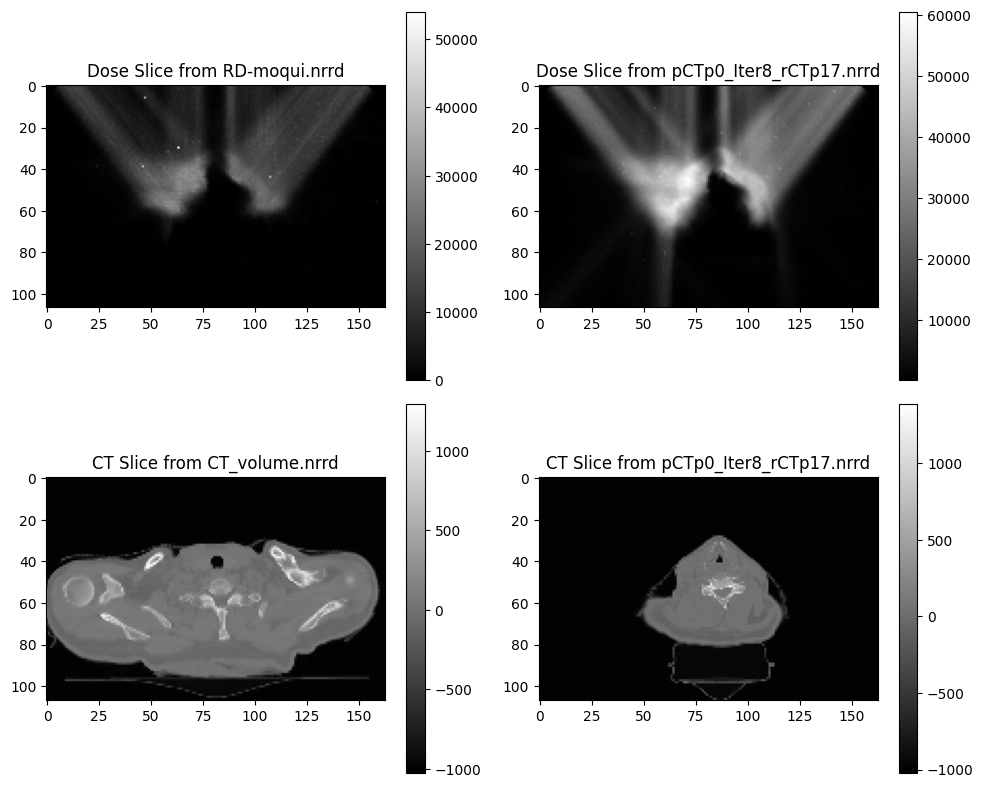

In [22]:
import itk
import matplotlib.pyplot as plt

# File paths for the two sets of images
dose_moving_path_1 = '/data/sama/Datasets/Dash_data/Dose_outlier/DBP_OP029/Iter8/rCTp17/X_14.61/RD-moqui.nrrd'
dose_moving_path_2 = '/data/bahrdoh/Datasets/Second_ds/nrrd/DBP_OP029/Iter8/DBP_OP029_pCTp0_Iter8_rCTp17.nrrd'
ct_moving_path_1 = '/data/sama/Datasets/Dash_data/Dose_outlier/DBP_OP029/Iter8/rCTp17/X_14.61/CT_volume.nrrd'
ct_moving_path_2 = '/data/bahrdoh/Datasets/Second_ds/ct_nrrd/DBP_OP029/Iter8/DBP_OP029_pCTp0_Iter8_rCTp17.nrrd'


# Reading the images using itk
dose_image_1 = itk.imread(dose_moving_path_1)
dose_image_2 = itk.imread(dose_moving_path_2)
ct_image_1 = itk.imread(ct_moving_path_1)
ct_image_2 = itk.imread(ct_moving_path_2)

# Convert to numpy arrays
dose_array_1 = itk.GetArrayViewFromImage(dose_image_1)
dose_array_2 = itk.GetArrayViewFromImage(dose_image_2)
ct_array_1 = itk.GetArrayViewFromImage(ct_image_1)
ct_array_2 = itk.GetArrayViewFromImage(ct_image_2)
# ct_array_2= np.flip(ct_array_2, axis=0)

# Selecting slice 80
slice_index = 40

dose_slice_1 = dose_array_1[slice_index, :, :]
dose_slice_2 = dose_array_2[slice_index, :, :]

ct_slice_1 = ct_array_1[slice_index, :, :]
ct_slice_2 = ct_array_2[slice_index, :, :]




# Plotting the dose images
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dose Slice from RD-moqui.nrrd')
plt.imshow(dose_slice_1, cmap='gray')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Dose Slice from pCTp0_Iter8_rCTp17.nrrd')
plt.imshow(dose_slice_2, cmap='gray')
plt.colorbar()

# Plotting the CT images
plt.subplot(2, 2, 3)
plt.title('CT Slice from CT_volume.nrrd')
plt.imshow(ct_slice_1, cmap='gray')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('CT Slice from pCTp0_Iter8_rCTp17.nrrd')
plt.imshow(ct_slice_2, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


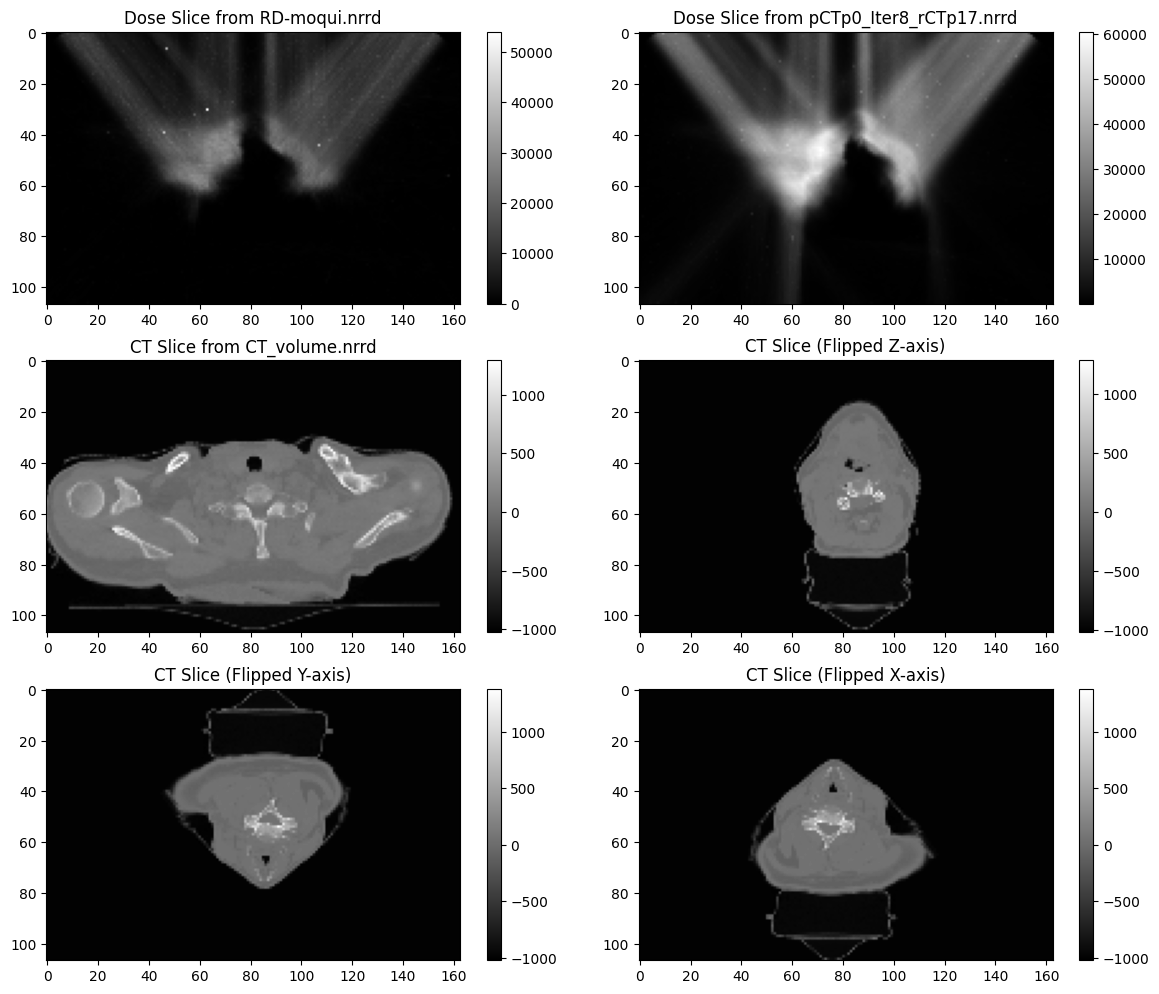

In [23]:
import itk
import numpy as np
import matplotlib.pyplot as plt

# File paths for the two sets of images
dose_moving_path_1 = '/data/sama/Datasets/Dash_data/Dose_outlier/DBP_OP029/Iter8/rCTp17/X_14.61/RD-moqui.nrrd'
dose_moving_path_2 = '/data/bahrdoh/Datasets/Second_ds/nrrd/DBP_OP029/Iter8/DBP_OP029_pCTp0_Iter8_rCTp17.nrrd'
ct_moving_path_1 = '/data/sama/Datasets/Dash_data/Dose_outlier/DBP_OP029/Iter8/rCTp17/X_14.61/CT_volume.nrrd'
ct_moving_path_2 = '/data/bahrdoh/Datasets/Second_ds/ct_nrrd/DBP_OP029/Iter8/DBP_OP029_pCTp0_Iter8_rCTp17.nrrd'

# Reading the images using itk
dose_image_1 = itk.imread(dose_moving_path_1)
dose_image_2 = itk.imread(dose_moving_path_2)
ct_image_1 = itk.imread(ct_moving_path_1)
ct_image_2 = itk.imread(ct_moving_path_2)

# Convert to numpy arrays
dose_array_1 = itk.GetArrayViewFromImage(dose_image_1)
dose_array_2 = itk.GetArrayViewFromImage(dose_image_2)
ct_array_1 = itk.GetArrayViewFromImage(ct_image_1)
ct_array_2 = itk.GetArrayViewFromImage(ct_image_2)

# Test different flips on ct_array_2
ct_array_2_flipped_z = np.flip(ct_array_2, axis=0)  # Flip along Z-axis
ct_array_2_flipped_y = np.flip(ct_array_2, axis=1)  # Flip along Y-axis
ct_array_2_flipped_x = np.flip(ct_array_2, axis=2)  # Flip along X-axis

# Selecting slice 40 for comparison
slice_index = 40

dose_slice_1 = dose_array_1[slice_index, :, :]
dose_slice_2 = dose_array_2[slice_index, :, :]

ct_slice_1 = ct_array_1[slice_index, :, :]
ct_slice_2_flipped_z = ct_array_2_flipped_z[slice_index, :, :]
ct_slice_2_flipped_y = ct_array_2_flipped_y[slice_index, :, :]
ct_slice_2_flipped_x = ct_array_2_flipped_x[slice_index, :, :]

# Plotting the dose images
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.title('Dose Slice from RD-moqui.nrrd')
plt.imshow(dose_slice_1, cmap='gray')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title('Dose Slice from pCTp0_Iter8_rCTp17.nrrd')
plt.imshow(dose_slice_2, cmap='gray')
plt.colorbar()

# Plotting the CT images (different flips)
plt.subplot(3, 2, 3)
plt.title('CT Slice from CT_volume.nrrd')
plt.imshow(ct_slice_1, cmap='gray')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title('CT Slice (Flipped Z-axis)')
plt.imshow(ct_slice_2_flipped_z, cmap='gray')
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title('CT Slice (Flipped Y-axis)')
plt.imshow(ct_slice_2_flipped_y, cmap='gray')
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title('CT Slice (Flipped X-axis)')
plt.imshow(ct_slice_2_flipped_x, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


In [7]:
# Function to read and return image size
def get_image_size(file_path):
    image = itk.imread(file_path)
    array = itk.GetArrayViewFromImage(image)
    return array.shape

# Determine the sizes of all images
dose_size_1 = get_image_size(dose_moving_path_1)
dose_size_2 = get_image_size(dose_moving_path_2)
ct_size_1 = get_image_size(ct_moving_path_1)
ct_size_2 = get_image_size(ct_moving_path_2)

sizes = {
    "Dose Image 1 (RD-moqui.nrrd)": dose_size_1,
    "Dose Image 2 (pCTp0_Iter8_rCTp17.nrrd)": dose_size_2,
    "CT Image 1 (CT_volume.nrrd)": ct_size_1,
    "CT Image 2 (pCTp0_Iter8_rCTp17.nrrd)": ct_size_2
}


sizes_df = pd.DataFrame(list(sizes.items()), columns=["Image", "Size"])
print(sizes_df)

                                    Image            Size
0            Dose Image 1 (RD-moqui.nrrd)  (97, 107, 163)
1  Dose Image 2 (pCTp0_Iter8_rCTp17.nrrd)  (97, 107, 163)
2             CT Image 1 (CT_volume.nrrd)  (97, 107, 163)
3    CT Image 2 (pCTp0_Iter8_rCTp17.nrrd)  (97, 107, 163)


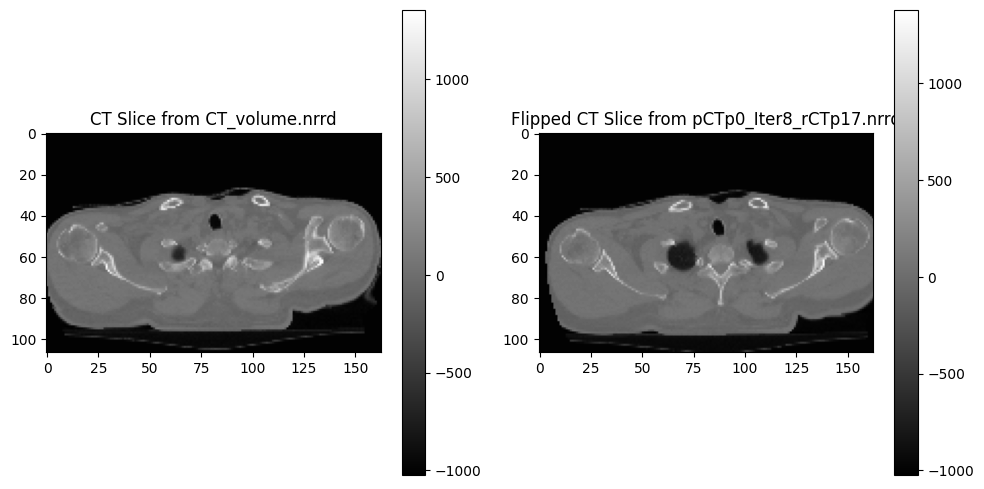

In [13]:
import itk
import numpy as np
import matplotlib.pyplot as plt

# Read both CT images
ct_image_1 = itk.imread('/data/sama/Datasets/Dash_data/Dose_outlier/DBP_OP029/Iter8/rCTp17/X_14.61/CT_volume.nrrd')
ct_image_2 = itk.imread('/data/bahrdoh/Datasets/Second_ds/ct_nrrd/DBP_OP029/Iter8/DBP_OP029_pCTp0_Iter8_rCTp17.nrrd')

# Convert to numpy arrays
ct_array_1 = itk.GetArrayViewFromImage(ct_image_1)
ct_array_2 = itk.GetArrayViewFromImage(ct_image_2)

# Flip one of the arrays along the Z-axis (axis 0)
ct_array_2_flipped = np.flip(ct_array_2, axis=0)

# Selecting a slice for visualization (slice 80)
slice_index = 80
ct_slice_1 = ct_array_1[slice_index, :, :]
ct_slice_2_flipped = ct_array_2_flipped[slice_index, :, :]

# Plot the original and flipped CT images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('CT Slice from CT_volume.nrrd')
plt.imshow(ct_slice_1, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Flipped CT Slice from pCTp0_Iter8_rCTp17.nrrd')
plt.imshow(ct_slice_2_flipped, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()
